In [1]:
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.
    ### Description
    Card Values:
    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.
    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.
    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    ### Action Space
    There are two actions: stick (0), and hit (1).
    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).
    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:
        +1.5 (if <a href="#nat">natural</a> is True)
        +1 (if <a href="#nat">natural</a> is False)
    ### Arguments
    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```
    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).
    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = '.'#os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = '.'#os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()


In [5]:
b=BlackjackEnv(render_mode="rgb_array", natural=True)

### Часть первая

#### Задание 1. Оценка простой стратегии

In [80]:
sum_result = 0.0
count = 1000000
for i in range(count):
    res = b.reset()
    terminated = False
    result = 0.0
    while res[0][0] < 19 and not terminated:
        res = b.step(1)
        terminated = res[2]
    if not terminated:
        res = b.step(0)
    sum_result += res[1]
sum_result / count

-0.1819785

Итого при усреднении по 1000000 партиям получается ~-0.18

#### Задание 2. Построение оптимальной стратегии

In [7]:
import random

In [84]:
def get_branch_result(branch):
    if 'result' in branch:
        return branch['result']
    else:
        sum_result = 0.0
        for k in branch.keys():
            if k != 'count':
                result = get_branch_result(branch[k])
                sum_result += result
        return sum_result

In [102]:
def get_strategy_result(strategy, count=100000):
    sum_result = 0.0
    for _ in range(count):
        res = b.reset()
        pointer = strategy
        terminated = False
        while not terminated:
            if res[0] in pointer and 0 in pointer[res[0]] and 1 in pointer[res[0]]:
                res_0 = get_branch_result(pointer[res[0]][0]) / pointer[res[0]][0]['count']
                res_1 = get_branch_result(pointer[res[0]][1]) / pointer[res[0]][1]['count']
                if res_0 > res_1:
                    pointer = pointer[res[0]][0]
                    res = b.step(0)
                else:
                    pointer = pointer[res[0]][1]
                    res = b.step(1)
                terminated = res[2]
            else:
                while not terminated:
                    res = b.step(int(random.random() > 0.5))
                    terminated = res[2]  
        sum_result += res[1]
    return sum_result / count

In [97]:
strategy = {}
count = 100000
step = 1000
hist = []
for i in range(count):
    start = b.reset()[0]
    if start not in strategy:
        strategy[start] = {'count': 0}
    pointer = strategy[start]
    pointer['count'] += 1
    terminated = False
    while not terminated:
        if 0 not in pointer:
            curr_step = 0
        elif 1 not in pointer:
            curr_step = 1
        else:
            curr_step = int(random.random() > 0.5)
        res = b.step(curr_step)
        curr = res[0]
        result = res[1]
        terminated = res[2]
        if curr_step not in pointer:
            pointer[curr_step] = {'count': 0}
        pointer = pointer[curr_step]
        pointer['count'] += 1
        if curr not in pointer:
            pointer[curr] = {'count': 0}
        pointer = pointer[curr]
        pointer['count'] += 1
    if 'result' not in pointer:
        pointer['result'] = 0.0
    pointer['result'] += result
    
    if i % step == 0:
        hist.append(get_strategy_result(strategy, count=100000))

#### Задание 3. Оценка построенной стратегии

In [103]:
get_strategy_result(strategy, count=100000)

-0.101005

Итого при усреднении по 100000 партиям получается ~-0.10

In [90]:
import matplotlib.pyplot as plt

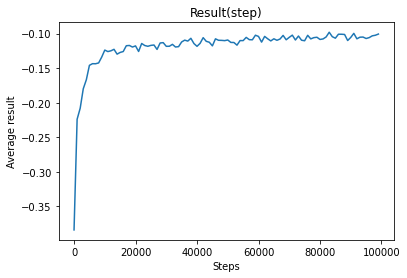

In [99]:
plt.plot(range(0, count, step), hist)
plt.title('Result(step)')
plt.xlabel('Steps')
plt.ylabel('Average result')
plt.show()

### Часть вторая

#### Задание 4. Реализация удвоения

In [119]:
class BlackjackEnvWithDouble(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.
    ### Description
    Card Values:
    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.
    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.
    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    ### Action Space
    There are two actions: stick (0), and hit (1).
    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).
    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:
        +1.5 (if <a href="#nat">natural</a> is True)
        +1 (if <a href="#nat">natural</a> is False)
    ### Arguments
    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```
    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).
    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double
            self.player.append(draw_card(self.np_random))
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 2.0
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = '.'#os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = '.'#os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()


#### Задание 5 Построение алгоритма с учетом удвоения

In [120]:
b=BlackjackEnvWithDouble(render_mode="rgb_array", natural=True)

In [123]:
def get_strategy_result(strategy, count=100000):
    sum_result = 0.0
    for _ in range(count):
        res = b.reset()
        pointer = strategy
        terminated = False
        while not terminated:
            if res[0] in pointer and 0 in pointer[res[0]] and 1 in pointer[res[0]] and 2 in pointer[res[0]]:
                res_0 = get_branch_result(pointer[res[0]][0]) / pointer[res[0]][0]['count']
                res_1 = get_branch_result(pointer[res[0]][1]) / pointer[res[0]][1]['count']
                res_2 = get_branch_result(pointer[res[0]][2]) / pointer[res[0]][2]['count']
                if res_0 > res_1 and res_0 > res_2:
                    pointer = pointer[res[0]][0]
                    res = b.step(0)
                elif res_1 > res_0 and res_1 > res_2:
                    pointer = pointer[res[0]][1]
                    res = b.step(1)
                else:
                    pointer = pointer[res[0]][2]
                    res = b.step(2)
                terminated = res[2]
            else:
                while not terminated:
                    res = b.step(random.randint(0, 2))
                    terminated = res[2]  
        sum_result += res[1]
    return sum_result / count

In [124]:
strategy = {}
count = 100000
step = 1000
hist = []
for i in range(count):
    start = b.reset()[0]
    if start not in strategy:
        strategy[start] = {'count': 0}
    pointer = strategy[start]
    pointer['count'] += 1
    terminated = False
    while not terminated:
        if 0 not in pointer:
            curr_step = 0
        elif 1 not in pointer:
            curr_step = 1
        elif 2 not in pointer:
            curr_step = 2
        else:
            curr_step = random.randint(0, 2)
        res = b.step(curr_step)
        curr = res[0]
        result = res[1]
        terminated = res[2]
        if curr_step not in pointer:
            pointer[curr_step] = {'count': 0}
        pointer = pointer[curr_step]
        pointer['count'] += 1
        if curr not in pointer:
            pointer[curr] = {'count': 0}
        pointer = pointer[curr]
        pointer['count'] += 1
    if 'result' not in pointer:
        pointer['result'] = 0.0
    pointer['result'] += result
    
    if i % step == 0:
        hist.append(get_strategy_result(strategy, count=100000))

#### Задание 5

In [125]:
get_strategy_result(strategy, count=100000)

-0.01943

Итого при усреднении по 100000 партиям получается ~-0.02

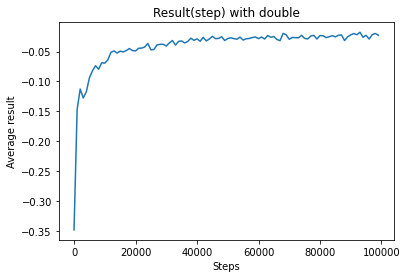

In [126]:
plt.plot(range(0, count, step), hist)
plt.title('Result(step) with double')
plt.xlabel('Steps')
plt.ylabel('Average result')
plt.show()

### Часть третья

In [344]:
num_of_decks = 6
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
start_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4 * num_of_decks

def draw_card(np_random, curr_deck):
    return int(np_random.choice(curr_deck))

class BlackjackEnvWithDoubleDeckCount(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.
    ### Description
    Card Values:
    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.
    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.
    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    ### Action Space
    There are two actions: stick (0), and hit (1).
    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).
    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:
        +1.5 (if <a href="#nat">natural</a> is True)
        +1 (if <a href="#nat">natural</a> is False)
    ### Arguments
    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```
    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).
    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False, update_deck=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode
        self.update_deck = update_deck
        self.curr_deck = start_deck.copy()
        self.player = []
        self.dealer = []

    def step(self, action):
        assert self.action_space.contains(action)
        curr_visible_cards = []
        if action == 2: # double
            card = draw_card(self.np_random, self.curr_deck)
            if self.update_deck:
                self.curr_deck.remove(card)
            self.player.append(card)
            terminated = True
            while sum_hand(self.dealer) < 17:
                card = draw_card(self.np_random, self.curr_deck)
                if self.update_deck:
                    self.curr_deck.remove(card)
                self.dealer.append(card)
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 2.0
            curr_visible_cards = self.player + self.dealer
        elif action == 1:  # hit: add a card to players hand and return
            card = draw_card(self.np_random, self.curr_deck)
            if self.update_deck:
                self.curr_deck.remove(card)
            self.player.append(card)
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
            curr_visible_cards = self.player + [self.dealer[0]]
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                card = draw_card(self.np_random, self.curr_deck)
                if self.update_deck:
                    self.curr_deck.remove(card)
                self.dealer.append(card)
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            curr_visible_cards = self.player + self.dealer

        if self.render_mode == "human":
            self.render()
        
        
        deck_updated = False
        if len(self.curr_deck) <= 15:
            self.curr_deck = start_deck.copy()
            deck_updated = True
        return self._get_obs(), reward, terminated, False, {}, curr_visible_cards, deck_updated

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))
    
    def get_curr_deck(self):
        return self.curr_deck + [self.dealer[1]]

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.player = []
        self.dealer = []
        card = draw_card(self.np_random, self.curr_deck)
        self.dealer.append(card)
        if self.update_deck:
            self.curr_deck.remove(card)
        card = draw_card(self.np_random, self.curr_deck)
        self.dealer.append(card)
        if self.update_deck:
            self.curr_deck.remove(card)
        dealer_hidden = self.dealer[1]
        card = draw_card(self.np_random, self.curr_deck)
        self.player.append(card)
        if self.update_deck:
            self.curr_deck.remove(card)
        card = draw_card(self.np_random, self.curr_deck)
        self.player.append(card)
        if self.update_deck:
            self.curr_deck.remove(card)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        deck_updated = False
        if len(self.curr_deck) <= 15:
            self.curr_deck = start_deck.copy()
            deck_updated = True
        return self._get_obs(), {}, self.player + [self.dealer[0]], deck_updated

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = '.'#os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = '.'#os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()

In [348]:
def get_branch_result(branch, deck):
    if 0 in branch:
        ke = [k for k in branch[0].keys() if k != 'count'][0]
        res_0 = branch[0][ke]['result'] / branch[0]['count']
    else:
        res_0 = 0.0
    if 1 in branch:
        kes = [k for k in branch[1].keys() if k != 'count']
        res_1 = 0
        sum_count = 0
        for ke in kes:
            if 'result' in branch[1][ke]:
                res_1 += branch[1][ke]['result'] * deck.count(branch[1][ke]['card']) / len(deck)
                sum_count += branch[1][ke]['count']
            else:
                if branch[1][ke]['card'] in deck:
                    d = deck.copy()
                    d.remove(branch[1][ke]['card'])
                    r0, r1, r2 = get_branch_result(branch[1][ke], d)
                    res_1 += max([r0, r1, r2])
                    sum_count += branch[1][ke]['count']
        if sum_count != 0:
            res_1 = res_1 / sum_count
        else:
            res_1 = -99999
    else:
        res_1 = -99999
    if 2 in branch:
        kes = [k for k in branch[2].keys() if k != 'count']
        res_2 = 0
        for ke in kes:
            res_2 += branch[2][ke]['result'] / branch[2][ke]['count'] * deck.count(branch[2][ke]['card']) / len(deck)
    else:
        res_2 = 0.0
    return (res_0, res_1, res_2)

In [349]:
def get_strategy_result(strategy, count=100000):
    sum_result = 0.0
    b=BlackjackEnvWithDoubleDeckCount(render_mode="rgb_array", natural=True, update_deck=True)
    for _ in range(count):
        res = b.reset()
        pointer = strategy
        terminated = False
        while not terminated:
            if res[0] in pointer and 0 in pointer[res[0]] and 1 in pointer[res[0]] and 2 in pointer[res[0]]:
                res_0, res_1, res_2 = get_branch_result(pointer[res[0]], b.get_curr_deck())
                
                if res_0 > res_1 and res_0 > res_2:
                    pointer = pointer[res[0]][0]
                    res = b.step(0)
                elif res_1 > res_0 and res_1 > res_2:
                    pointer = pointer[res[0]][1]
                    res = b.step(1)
                else:
                    pointer = pointer[res[0]][2]
                    res = b.step(2)
                terminated = res[2]
            else:
                while not terminated:
                    res = b.step(random.randint(0, 2))
                    terminated = res[2]  
        sum_result += res[1]
    return sum_result / count

In [350]:
strategy = {}
count = 100000
step = 1000
hist = []
b=BlackjackEnvWithDoubleDeckCount(render_mode="rgb_array", natural=True, update_deck=True)
for i in range(count):
    r = b.reset()
    start = r[0]
    if start not in strategy:
        strategy[start] = {'count': 0}
    pointer = strategy[start]
    pointer['count'] += 1
    terminated = False
    while not terminated:
        if 0 not in pointer:
            curr_step = 0
        elif 1 not in pointer:
            curr_step = 1
        elif 2 not in pointer:
            curr_step = 2
        else:
            curr_step = random.randint(0, 2)
        res = b.step(curr_step)
        curr = res[0]
        result = res[1]
        terminated = res[2]
        if curr_step not in pointer:
            pointer[curr_step] = {'count': 0}
        pointer = pointer[curr_step]
        pointer['count'] += 1
        if curr_step == 0:
            card = -1
        else:
            card = res[5][-2]
        if curr not in pointer:
            pointer[curr] = {'count': 0}
        pointer = pointer[curr]
        pointer['count'] += 1
        pointer['card'] = card
    if 'result' not in pointer:
        pointer['result'] = 0.0
    pointer['result'] += result
    
    if i % step == 0:
        e = get_strategy_result(strategy, count=100000)
        hist.append(e)

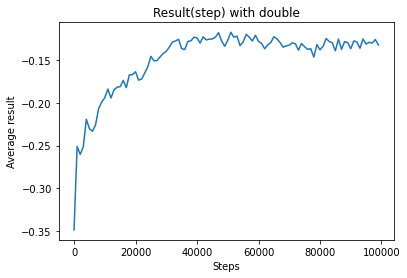

In [351]:
plt.plot(range(0, count, step), hist)
plt.title('Result(step) with double')
plt.xlabel('Steps')
plt.ylabel('Average result')
plt.show()

In [352]:
get_strategy_result(strategy, count=100000)

-0.13221

Реализовать явный учет подсчета карт, к сожалению, не получилось, результат оказывается хуже, чем был

In [353]:
def get_branch_result(branch):
    if 'result' in branch:
        return branch['result']
    else:
        sum_result = 0.0
        for k in branch.keys():
            if k != 'count' and k != 'card':
                result = get_branch_result(branch[k])
                sum_result += result
        return sum_result

In [354]:
def get_strategy_result(strategy, count=100000):
    sum_result = 0.0
    b=BlackjackEnvWithDoubleDeckCount(render_mode="rgb_array", natural=True, update_deck=True)
    for _ in range(count):
        res = b.reset()
        pointer = strategy
        terminated = False
        while not terminated:
            if res[0] in pointer and 0 in pointer[res[0]] and 1 in pointer[res[0]] and 2 in pointer[res[0]]:
                res_0 = get_branch_result(pointer[res[0]][0]) / pointer[res[0]][0]['count']
                res_1 = get_branch_result(pointer[res[0]][1]) / pointer[res[0]][1]['count']
                res_2 = get_branch_result(pointer[res[0]][2]) / pointer[res[0]][2]['count']
                
                if res_0 > res_1 and res_0 > res_2:
                    pointer = pointer[res[0]][0]
                    res = b.step(0)
                elif res_1 > res_0 and res_1 > res_2:
                    pointer = pointer[res[0]][1]
                    res = b.step(1)
                else:
                    pointer = pointer[res[0]][2]
                    res = b.step(2)
                terminated = res[2]
            else:
                while not terminated:
                    res = b.step(random.randint(0, 2))
                    terminated = res[2]  
        sum_result += res[1]
    return sum_result / count

In [355]:
strategy = {}
count = 100000
step = 1000
hist = []
b=BlackjackEnvWithDoubleDeckCount(render_mode="rgb_array", natural=True, update_deck=True)
for i in range(count):
    r = b.reset()
    start = r[0]
    if start not in strategy:
        strategy[start] = {'count': 0}
    pointer = strategy[start]
    pointer['count'] += 1
    terminated = False
    while not terminated:
        if 0 not in pointer:
            curr_step = 0
        elif 1 not in pointer:
            curr_step = 1
        elif 2 not in pointer:
            curr_step = 2
        else:
            curr_step = random.randint(0, 2)
        res = b.step(curr_step)
        curr = res[0]
        result = res[1]
        terminated = res[2]
        if curr_step not in pointer:
            pointer[curr_step] = {'count': 0}
        pointer = pointer[curr_step]
        pointer['count'] += 1
        if curr_step == 0:
            card = -1
        else:
            card = res[5][-2]
        if curr not in pointer:
            pointer[curr] = {'count': 0}
        pointer = pointer[curr]
        pointer['count'] += 1
        pointer['card'] = card
    if 'result' not in pointer:
        pointer['result'] = 0.0
    pointer['result'] += result
    
    if i % step == 0:
        e = get_strategy_result(strategy, count=100000)
        hist.append(e)

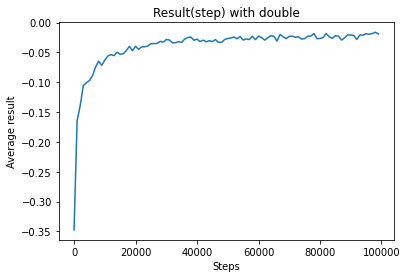

In [356]:
plt.plot(range(0, count, step), hist)
plt.title('Result(step) with double')
plt.xlabel('Steps')
plt.ylabel('Average result')
plt.show()

In [357]:
get_strategy_result(strategy, count=100000)

-0.018945

Неявный учет ограниченности колоды дает результат чуть лучше, но незначительно и тоже обыграть казино не удается